In [137]:
import os
import sys
os.environ['TRANSFORMERS_CACHE'] = '/projectnb/cs505/mahirp/cache'
os.environ['PREFIX_PATH']="/projectnb/cs505/mahirp/python"
os.environ['TFHUB_CACHE_DIR']='/projectnb/cs505/mahirp/tfcache'
sys.path.append('/projectnb/cs505/mahirp/python/bin')
sys.path.append('/projectnb/cs505/mahirp/cache')
sys.path.append('/projectnb/cs505/mahirp/tfcache')
sys.path.append('/projectnb/cs505/mahirp/usr/bin')


In [ ]:
!pip install --ignore-installed --prefix=$PREFIX_PATH transformers sklearn



In [2]:
from transformers import pipeline, set_seed
import re
import pandas as pd
import tensorflow_hub as hub
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
tf.device('/GPU:0')
import numpy as np
import nltk
nltk.data.path.append("/projectnb/cs505/mahirp/nltk/")
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
loadFromFile=False

prepend=datetime.now().strftime("%m-%d-%Y-%H-%M-%S-")

stop_words = set(stopwords.words('english')) 

In [3]:
useGlove=True
if useGlove:
    embeddings_index = {}
    f = open('glove.42B.300d.txt')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))

Found 1917494 word vectors.


In [18]:
prepend=datetime.now().strftime("%m-%d-%Y-%H-%M-%S-")
dataset = pd.read_excel('CS505-gunviolence/GVFC_AnnotatedHeadlines.xlsx', index_col=0)
if not loadFromFile:
    true=dataset[dataset['V3relevance']==1]
    false=dataset[dataset['V3relevance']==0]
    trainDataset=true.sample(frac=0.7)
    testDataset=true.drop(trainDataset.index)
    ftrainDataset=false.sample(frac=0.7)
    ftestDataset=false.drop(ftrainDataset.index)
    trainDataset=trainDataset.append(ftrainDataset).sample(frac=1)
    testDataset=testDataset.append(ftestDataset).sample(frac=1)
    indices=np.array(trainDataset.index)
    np.save(open('train_indices.npy','wb'),indices)
else:
    print('loaded from storage')
    indices=np.load(open('train_indices.npy','rb'))
    trainDataset=dataset.iloc[indices]
    testDataset=dataset.drop(indices)
print(len(trainDataset))
print(len(testDataset))

910
390


In [22]:
len(testDataset)

390

In [4]:

# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
generator = pipeline('text-generation', model='gpt2',device=0)
tokenizer=generator.tokenizer

INFO:absl:Using /projectnb/cs505/mahirp/tfcache to cache modules.
All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [5]:
def generateDataset(dataset,isTest=False):
    df = pd.DataFrame(columns=['original','headline','generated','relevant'])
    c=0
    gen_seq=3 if not isTest else 1
    for original,headline,caption,relevant in zip(dataset['whole_text'],dataset['news_title'],dataset['generated_caption_of_lead_image'],dataset['V3relevance']):
        set_seed(random.randint(1,1000))
        print("{}/{}".format(c,len(dataset)))
        c+=1
        text=generator(caption.lower(), max_length=min(100,len(original)), num_return_sequences=gen_seq)
        headLineText=generator(headline.lower(),max_length=min(100,len(original)),num_return_sequences=gen_seq)
        for t,h in zip(text,headLineText):
          df=df.append({'original':original,'headline':h['generated_text'],'generated': t['generated_text'],'relevant':relevant},ignore_index = True)
    return df

In [6]:
regexMap = { r"https?://[a-zA-Z0-9./]*": "", r"@[\w]*": " ", r"#[\w]*": " ",r"\n":" ",r"\\":" ",r"[^a-zA-Z\s]":"",r"[\s]+": " "}


def cleanData(text):
    text=text.strip()
    for regx in regexMap.keys():
        text = re.sub(regx, regexMap[regx], text)
    return text

In [9]:
def getEmbeddings(text):
    global useGlove
    text=text.lower()
    if not useGlove:
        print('\rusing USE',end='')
        return embed([text]).numpy().astype(np.float)
    else:
        print('\rusing GLOVE',end='')
        embedding_matrix = np.zeros((1,512),dtype=np.float)
        tokens=word_tokenize(text)
        tokens=[word for word in tokens if word not in stop_words]
        cnt=0
        for i,word in enumerate(tokens):
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                cnt+=1
                embedding_vector = np.pad(embedding_vector, (0,212), 'constant')
                embedding_matrix = embedding_matrix + ((embedding_vector-embedding_matrix)/cnt)
        return embedding_matrix

In [ ]:
prepend=datetime.now().strftime("%m-%d-%Y-%H-%M-%S-")
# trainDF = pd.read_csv('CS505-gunviolence/04-25-2021-05-40-38-raw_train_relevanceDatasetV3.csv')
trainDF= generateDataset(trainDataset)
trainDF['generated']=list(map(cleanData,trainDF['generated']))
trainDF['headline']=list(map(cleanData,trainDF['headline']))
trainDF['original']=list(map(cleanData,trainDF['original']))
trainDF.to_csv('CS505-gunviolence/'+prepend+'raw_train_relevanceDatasetV3.csv',index=False)
useGlove=False
prefix='_GLOVE_' if useGlove else '_USE_'
trainDF['generated']=list(map(getEmbeddings,trainDF['generated']))
print('done')
trainDF['headline']=list(map(getEmbeddings,trainDF['headline']))
print('done')
trainDF['original']=list(map(getEmbeddings,trainDF['original']))

trainDF.to_csv('CS505-gunviolence/'+prepend+prefix+'train_relevanceDatasetV3.csv',index=False)
trainDF = pd.read_csv('CS505-gunviolence/'+prepend+'raw_train_relevanceDatasetV3.csv'')
useGlove=True
prefix='_GLOVE_' if useGlove else '_USE_'
trainDF['generated']=list(map(getEmbeddings,trainDF['generated']))
print('done')
trainDF['headline']=list(map(getEmbeddings,trainDF['headline']))
print('done')
trainDF['original']=list(map(getEmbeddings,trainDF['original']))

trainDF.to_csv('CS505-gunviolence/'+prepend+prefix+'train_relevanceDatasetV3.csv',index=False)

In [ ]:
# testDF  = pd.read_csv('CS505-gunviolence/04-25-2021-05-40-38-raw_test_relevanceDatasetV3.csv')
testDF=generateDataset(testDataset,True)
testDF['generated']=list(map(cleanData,testDF['generated']))
testDF['headline']=list(map(cleanData,testDF['headline']))
testDF['original']=list(map(cleanData,testDF['original']))
testDF.to_csv('CS505-gunviolence/'+prepend+'raw_test_relevanceDatasetV3.csv',index=False)
useGlove=False
prefix='_GLOVE_' if useGlove else '_USE_'
testDF['generated']=list(map(getEmbeddings,testDF['generated']))
print('done')
testDF['headline']=list(map(getEmbeddings,testDF['headline']))
print('done')
testDF['original']=list(map(getEmbeddings,testDF['original']))
testDF.to_csv('CS505-gunviolence/'+prepend+prefix+'test_relevanceDatasetV3.csv',index=False)
testDF  = pd.read_csv('CS505-gunviolence/'+prepend+'raw_test_relevanceDatasetV3.csv')
useGlove=True
prefix='_GLOVE_' if useGlove else '_USE_'
testDF['generated']=list(map(getEmbeddings,testDF['generated']))
print('done')
testDF['headline']=list(map(getEmbeddings,testDF['headline']))
print('done')
testDF['original']=list(map(getEmbeddings,testDF['original']))
testDF.to_csv('CS505-gunviolence/'+prepend+prefix+'test_relevanceDatasetV3.csv',index=False)

In [79]:
def getEnsembleModel(embeddingDims=512):
    inp=tf.keras.Input(shape=(3,embeddingDims),name='embeddings')
    inp2=tf.keras.Input(shape=(3,embeddingDims),name='glove_embeddings')
    x=tf.keras.layers.Dense(256,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=8e-6),name='features01')(inp)
    x=tf.keras.layers.Flatten()(x)
    x=tf.keras.layers.Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=8e-5),name='features')(x)
    x=tf.keras.layers.Dense(2,activation='softmax')(x)
    
    y=tf.keras.layers.Dense(256,activation='relu',name='features02',kernel_regularizer=tf.keras.regularizers.l2(l2=8e-6))(inp2)
    y=tf.keras.layers.Flatten()(y)
    y=tf.keras.layers.Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=8e-5),name='features2')(y)
    y=tf.keras.layers.Dense(2,activation='softmax')(y)
    z=tf.keras.layers.Average()([x, y])
    return tf.keras.Model([inp, inp2],z)

def getModel(embeddingDims=512,isGlove=False):
    if not isGlove:
        inp=tf.keras.Input(shape=(3,embeddingDims),name='embeddings')
    else:
        inp=tf.keras.Input(shape=(3,embeddingDims),name='glove_embeddings')
        
    x=tf.keras.layers.Dense(256,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=2e-6),name='features0')(inp)
    x=tf.keras.layers.Flatten()(x)
    x=tf.keras.layers.Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=8e-5),name='features')(x)
    x=tf.keras.layers.Dense(2,activation='softmax')(x)
    return tf.keras.Model(inp,x)
    
def getAutoEncoder():
    inp = tf.keras.Input(shape=(512))
    x=tf.keras.layers.Flatten()(inp)
    x=tf.keras.layers.Dense(128)(x)
    x=tf.keras.layers.Dense(512)(x)
    return tf.keras.Model(inp,x)
    

In [113]:
model=getModel()
gloveModel=getModel(isGlove=True)
ensembleModel=getEnsembleModel()

In [105]:
model.summary()
gloveModel.summary()
ensembleModel.summary()

Model: "functional_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeddings (InputLayer)      [(None, 3, 512)]          0         
_________________________________________________________________
features0 (Dense)            (None, 3, 256)            131328    
_________________________________________________________________
flatten_36 (Flatten)         (None, 768)               0         
_________________________________________________________________
features (Dense)             (None, 64)                49216     
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 130       
Total params: 180,674
Trainable params: 180,674
Non-trainable params: 0
_________________________________________________________________
Model: "functional_57"
_________________________________________________________________
Layer (type)            

In [19]:
# df=pd.read_csv('CS505-gunviolence/'+prepend+'train_relevanceDatasetV3.csv')
# df = pd.read_csv('CS505-gunviolence/04-19-2021-04-43-45-train_relevanceDatasetV3.csv')
df = pd.read_csv('CS505-gunviolence/04-25-2021-04-41-28-_USE_train_relevanceDatasetV3.csv')
df2 = pd.read_csv('CS505-gunviolence/04-25-2021-04-41-28-_GLOVE_train_relevanceDatasetV3.csv')
labels=df.pop('relevant')

In [20]:
regexMap = { r"\n":" ",r"[\s]+": ",",r"\[,":"["}


In [119]:
def generateNPDataset(dataframe):
    features=[]
    for index,data in dataframe.iterrows():
        c1=np.array(eval(cleanData(data['headline'])),dtype=np.float)
        c2=np.array(eval(cleanData(data['generated'])),dtype=np.float)
        c3=np.array(eval(cleanData(data['original'])),dtype=np.float)
#         features.append(c1.T@((c2+c3)/2))
        features.append(np.vstack((c1,c2,c3)))
    features=np.array(features,dtype=np.float)
    return features

In [22]:
features=generateNPDataset(df)

In [23]:

glove_features=generateNPDataset(df2)

In [24]:
print(features.shape)
print(glove_features.shape)

(2730, 3, 512)
(2730, 3, 512)


In [49]:
dataset = tf.data.Dataset.from_tensor_slices(({'embeddings':features,'glove_embeddings':glove_features}, tf.keras.utils.to_categorical(labels)))


In [50]:
l=len(dataset)
dataset=dataset.shuffle(l+1).batch(16)
l=len(dataset)
train_set=dataset.take(int(l*0.75))
test_set=dataset.skip(int(l*0.75))
val_set=test_set.take(int(l*0.75*0.10))
test_set=test_set.skip(int(l*0.75*0.10))
print(len(test_set))
print(len(train_set))
print(len(val_set))

31
128
12


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=5e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
gloveModel.compile(optimizer=tf.keras.optimizers.Adam(lr=5e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
ensembleModel.compile(optimizer=tf.keras.optimizers.Adam(lr=5e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history=model.fit(train_set,validation_data=val_set,epochs=8,shuffle=True)
history=ensembleModel.fit(train_set,validation_data=val_set,epochs=10,shuffle=True)
history=gloveModel.fit(train_set,validation_data=val_set,epochs=7,shuffle=True)

In [107]:
model.evaluate(test_set)
gloveModel.evaluate(test_set)
ensembleModel.evaluate(test_set)

31/31 [==============================] - 0s 1ms/step - loss: 0.6507 - accuracy: 0.6837


[0.6507479548454285, 0.6836734414100647]

In [118]:
model.save(prepend+'final_USE.h5')
gloveModel.save(prepend+'final_GLOVE.h5')
ensembleModel.save(prepend+'final_ENSEMBLE.h5')

In [29]:
results={}
sampleCount=0
testDF = pd.read_csv('CS505-gunviolence/04-25-2021-04-41-28-_USE_test_relevanceDatasetV3.csv')
testDF2= pd.read_csv('CS505-gunviolence/04-25-2021-04-41-28-_GLOVE_test_relevanceDatasetV3.csv')
tfeatures=[]
tlabels=tf.keras.utils.to_categorical(testDF.pop('relevant'))
tfeatures=generateNPDataset(testDF)
tfeatures_glove=generateNPDataset(testDF2)

In [30]:
print(tfeatures.shape)
test_dataset = tf.data.Dataset.from_tensor_slices(({'embeddings':tfeatures,'glove_embeddings':tfeatures_glove}, tlabels)).batch(32)

(390, 3, 512)


In [122]:
# test_input=np.array(test_input,dtype=np.float)
# test_label=np.array(test_label)
model.evaluate(test_dataset)
gloveModel.evaluate(test_dataset)
ensembleModel.evaluate(test_dataset)


13/13 [==============================] - 0s 2ms/step - loss: 0.6662 - accuracy: 0.6385


[0.666168212890625, 0.6384615302085876]

In [120]:
from sklearn.manifold import TSNE
def getIntermediate(model,layers):
    x=None
    for layer in layers:
        if x is None:
            x=model.get_layer(layer).output
        else:
            x=model.get_layer(layer)(x)
    return tf.keras.models.Model(inputs=model.input,outputs=x)

def getTSNEData(model,listOfLayers):
    intermediate_layer_model = getIntermediate(model,listOfLayers)
    predict = intermediate_layer_model.predict(test_dataset)
    tsne = TSNE(n_components=2, verbose=1, random_state=42,n_jobs=16,method='exact')
    return tsne.fit_transform(predict)
    

In [128]:
import matplotlib.pyplot as plt
%matplotlib inline
def plotTSNE(model,listOfLayers=['features']):
    z=getTSNEData(model,listOfLayers)
    classes = [1,0]
    label=['Relevant','Not Relevant']
    tsnedataset={}
    for c in classes:
        tsnedataset[c]=np.where(tlabels[:,0]==c)
    colors=['#e76f51','#2a9d8f','#1d3557','#a8dadc']
    for c in classes:
        plt.scatter(z[tsnedataset[c],0],z[tsnedataset[c],1],c=colors[c],label=label[c])
    plt.legend(loc='best')
    plt.title(model.name)
    plt.show()

/share/pkg.7/tensorflow/2.3.1/install/lib/SCC/../python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['glove_embeddings'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 390 / 390
[t-SNE] Mean sigma: 0.141848
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.503215
[t-SNE] KL divergence after 1000 iterations: 0.807066


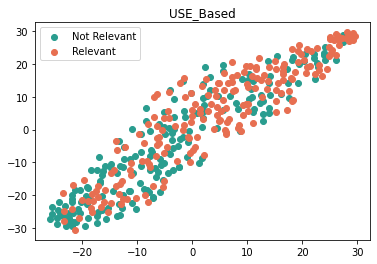

In [132]:
model._name='USE_Based'
plotTSNE(model)

/share/pkg.7/tensorflow/2.3.1/install/lib/SCC/../python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['embeddings'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 390 / 390
[t-SNE] Mean sigma: 0.179231
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.086230
[t-SNE] KL divergence after 1000 iterations: 0.913512


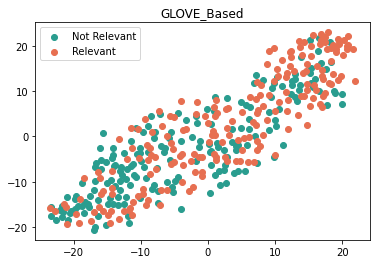

In [133]:
gloveModel._name='GLOVE_Based'
plotTSNE(gloveModel)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 390 / 390
[t-SNE] Mean sigma: 0.160090
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.408855
[t-SNE] KL divergence after 1000 iterations: 0.698121


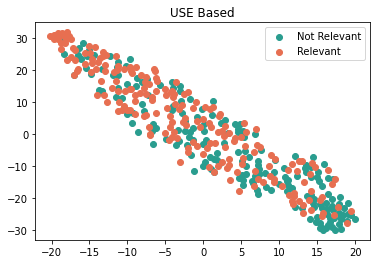

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 390 / 390
[t-SNE] Mean sigma: 0.195384
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.365957
[t-SNE] KL divergence after 1000 iterations: 0.926434


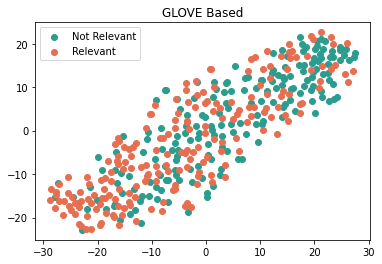

In [134]:
ensembleModel._name='USE Based'
plotTSNE(ensembleModel)
ensembleModel._name='GLOVE Based'
plotTSNE(ensembleModel,['features2'])